# Importando TensorFlow e Keras

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Conjunto de dados do FLW
Donwload do arquivo ltw.tgz contendo 172 MB de imagens:

In [3]:
!curl -O "http://vis-www.cs.umass.edu/lfw/lfw.tgz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  172M  100  172M    0     0  26.7M      0  0:00:06  0:00:06 --:--:-- 31.6M


Descompactando lfw.tgz.

In [4]:
!tar -xzvf lfw.tgz

A saída de streaming foi truncada nas últimas 5000 linhas.
lfw/Luis_Sanchez/
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw

# Filtra imagens corrompidas
Filtra imagens mal codificadas, que não apresentam a string "JFIF" no cabecalho.

In [5]:
import os

num_skipped = 0
for folder_name in os.listdir("lfw"):
    folder_path = os.path.join("lfw", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


# Analisando os dados obtidos pelo FLW
Verificando quantas pessoas existe no acervo do FLW.

In [6]:
qt = len([item for item in os.listdir("lfw")])
print(f'{qt} pessoas')

5749 pessoas


Verificando as pessoas com maior acervo de imagens

In [7]:
import operator

folders = []
for folder_name in os.listdir("lfw"):
    folder_path = os.path.join("lfw", folder_name)
    qt = len(os.listdir(folder_path))
    if qt >= 100:
        folders.append({'folder': folder_name, 'qt': qt})

folders.sort(key=operator.itemgetter('qt', 'folder'))
for f in folders:
    folder = f['folder']
    qt = f['qt']
    print(f'{folder:20} ==> {qt:4}')

Gerhard_Schroeder    ==>  109
Donald_Rumsfeld      ==>  121
Tony_Blair           ==>  144
Colin_Powell         ==>  236
George_W_Bush        ==>  530


# Cria pasta de processamento
Como podemos notar o FLW fornece relamente um número muito grande de faces para serem analizadas, porem a grande maioria das pessoas não possuem um número significativo de faces.
Desta forma criaremos uma pasta com o objetivo de filtrar as pessoas que serão processadas.

In [8]:
dirName = 'lfw_dados'
if not os.path.exists(dirName):
    os.makedirs(dirName)

dirName = 'lfw_dados/0'
if not os.path.exists(dirName):
    os.makedirs(dirName)
    
dirName = 'lfw_dados/1'
if not os.path.exists(dirName):
    os.makedirs(dirName)

Para fins didáticos iremos utilizar como exemplo Colin Powell como 0 e Tony Blair como 1.

In [9]:
from distutils.dir_util import copy_tree
copy_tree('lfw/Colin_Powell', 'lfw_dados/0')
copy_tree('lfw/Tony_Blair', 'lfw_dados/1')
print('ok')

ok


# Gera os conjuntos de dados
Cria um conjunto de dados de treinamento e outro para validação, sendo que as imagens obtidas estão em um tamanho padrão (250x250).

In [10]:
image_size = (250, 250)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="lfw_dados", validation_split=0.2, subset="training",
    seed=1337, image_size=image_size, batch_size=32
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="lfw_dados", validation_split=0.2, subset="validation",
    seed=1337, image_size=image_size, batch_size=32
)

Found 380 files belonging to 2 classes.
Using 304 files for training.
Found 380 files belonging to 2 classes.
Using 76 files for validation.


# Visualize os dados

Aqui estão as primeiras 9 imagens do conjunto de dados treinados. Sendo 0 para "Colin_Powell" e 1 para "Tony_Blair".

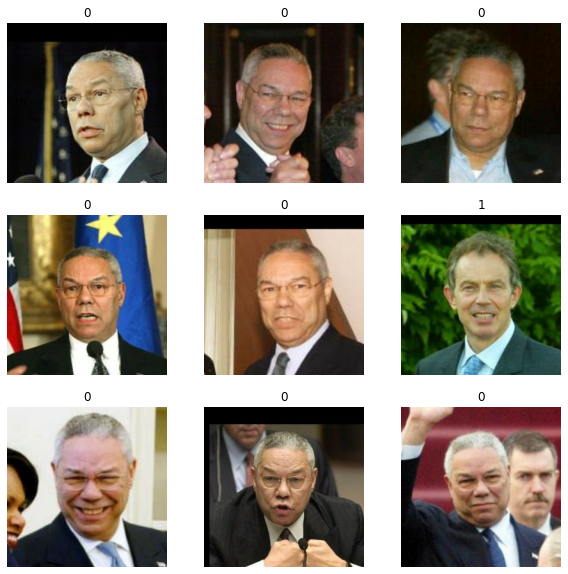

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Aumenta artificialmente o condjunto de dados

Uma vez que o conjunto de dados não é muito grande, é recomendado introduzir artificialmente transformações aleatórias, porém realistas, como inversão horizontal aleatória ou pequenas rotações. Desta forma ajuda a expor o modelo a diferentes situações do dia a dia, ao mesmo tempo que desacelera o overfliting.

In [12]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

Exemplo de imagens introduzadas artificiamente a partir da primeira imagem do conjunto de dados.

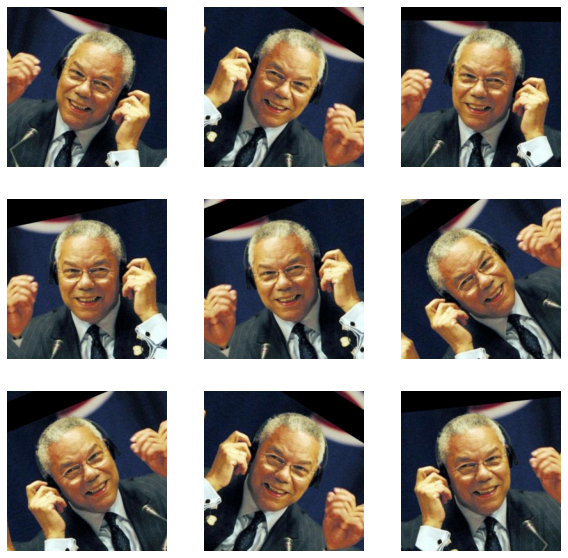

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Pré-busca os conjuntos de dados visando melhorar a latência e o redimento ao custo de usar mais memória.

In [14]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Cria o modelo
Cria o modelo baseado em uma pequena versão da rede Xception.

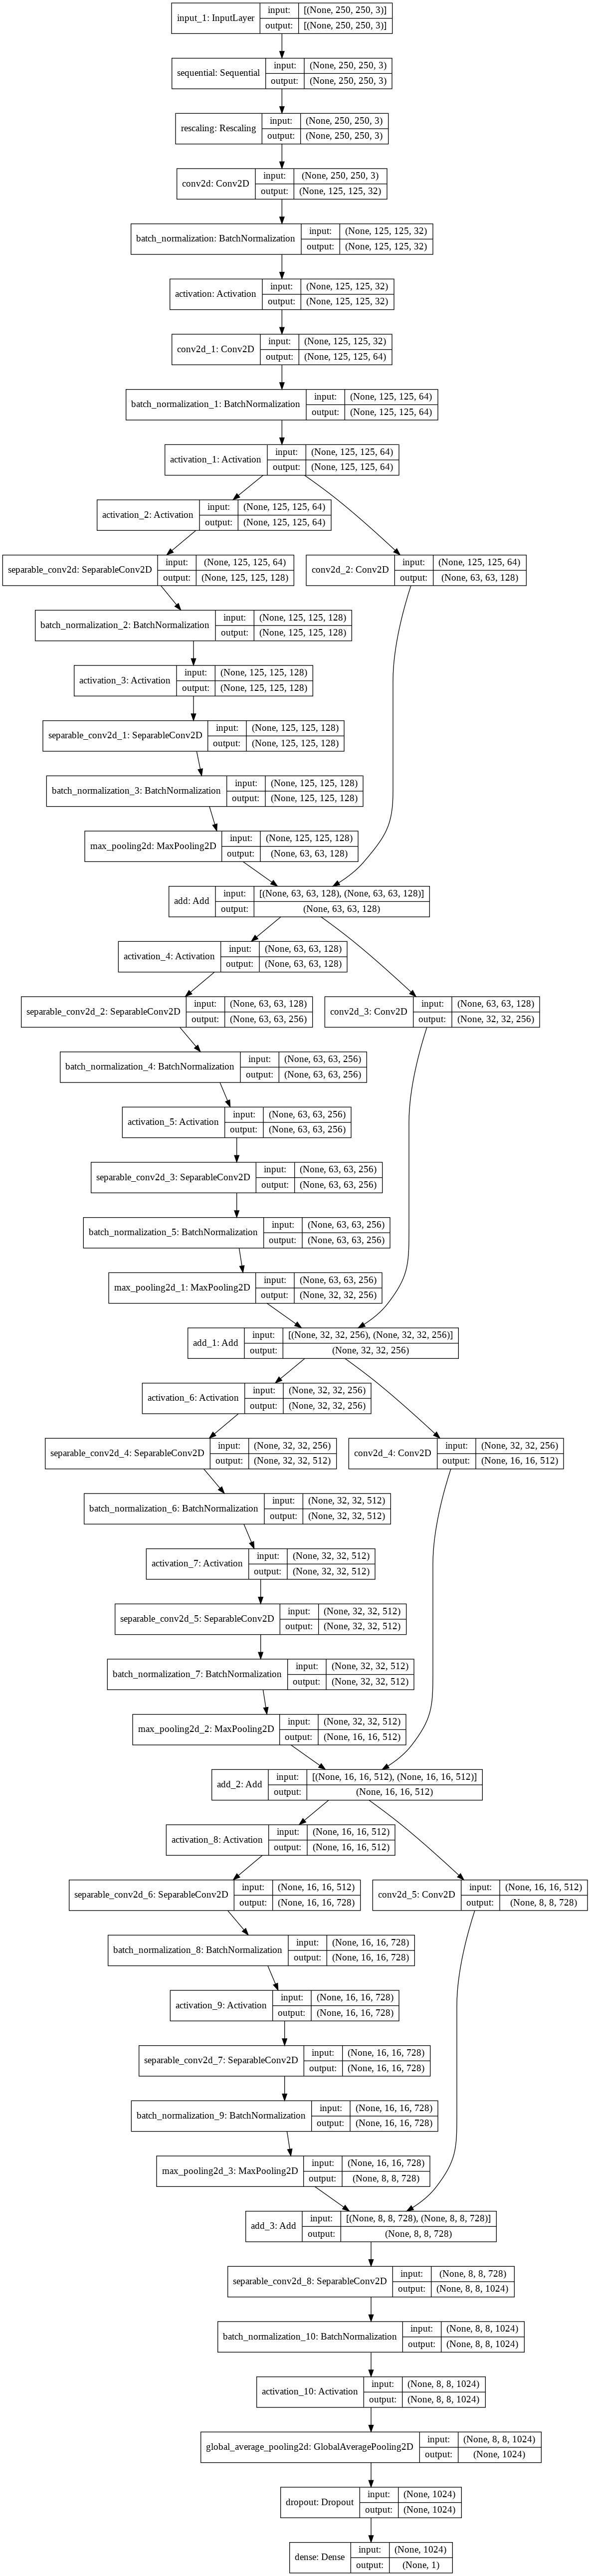

In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)



model = make_model(input_shape=image_size + (3,), num_classes=2)

keras.utils.plot_model(model, show_shapes=True)

# Treine o modelo
O modelo será treinado por 50 épocas.

In [19]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
10/10 [==============================] - 12s 956ms/step - loss: 0.2526 - accuracy: 0.9079 - val_loss: 0.7345 - val_accuracy: 0.4474


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
10/10 [==============================] - 10s 919ms/step - loss: 0.1677 - accuracy: 0.9309 - val_loss: 0.7361 - val_accuracy: 0.4474
Epoch 3/50
10/10 [==============================] - 9s 902ms/step - loss: 0.1448 - accuracy: 0.9408 - val_loss: 0.7550 - val_accuracy: 0.4474
Epoch 4/50
10/10 [==============================] - 9s 910ms/step - loss: 0.1235 - accuracy: 0.9572 - val_loss: 0.7671 - val_accuracy: 0.4474
Epoch 5/50
10/10 [==============================] - 9s 889ms/step - loss: 0.0800 - accuracy: 0.9737 - val_loss: 0.8390 - val_accuracy: 0.4474
Epoch 6/50
10/10 [==============================] - 9s 908ms/step - loss: 0.0500 - accuracy: 0.9868 - val_loss: 0.9119 - val_accuracy: 0.4474
Epoch 7/50
10/10 [==============================] - 9s 904ms/step - loss: 0.0380 - accuracy: 0.9901 - val_loss: 0.9288 - val_accuracy: 0.4474
Epoch 8/50
10/10 [==============================] - 9s 901ms/step - loss: 0.0229 - accuracy: 0.9934 - val_loss: 0.9287 - val_accuracy: 0.4474
Epoch

# Executar inferência de novos dados.


Observe que ao analizarnos novamente uma imagem da Serena Williams o modelo informa 86% de ser a Serena.

In [20]:
img = keras.preprocessing.image.load_img(
    "lfw/Colin_Powell/Colin_Powell_0003.jpg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(img_array)
score = predictions[0]
print("A imagem é %.2f%% Colin_Powell e %.2f%% Tony_Blair."
      % (100 * (1 - score), 100 * score))


[0.00188051]
A imagem é 99.81% Colin_Powell e 0.19% Tony_Blair.


Enquanto uma imagem do Vladimir Putin

In [21]:
img2 = keras.preprocessing.image.load_img(
    "lfw/Tony_Blair/Tony_Blair_0013.jpg", target_size=image_size)
img_array2 = keras.preprocessing.image.img_to_array(img2)
img_array2 = tf.expand_dims(img_array2, 0)  # Create batch axis
predictions2 = model.predict(img_array2)
score2 = predictions2[0]
print("A imagem é %.2f%% Colin_Powell e %.2f%% Tony_Blair."
      % (100 * (1 - score2), 100 * score2))

[0.9990289]
A imagem é 0.10% Colin_Powell e 99.90% Tony_Blair.
